In [16]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from tqdm.notebook import tqdm

%matplotlib inline

# Сырые данные

## Считываем данные из .csv

Некоторые данные (такие как рубрики и признаки), представлены строками значений. Преобразуем их в списки чисел. 

In [17]:
to_list = lambda rubrics: [int(rubric) for rubric in str(rubrics).split(' ')]
def apply_to_columns(df, columns, func=to_list):
    for column in columns:
        df.loc[~df[column].isnull(), column] = df.loc[~df[column].isnull(), column].apply(func)

В первую очередь нам понадобятся данные по __пользователям__, __организациям__ и сами __отзывы__. 

In [18]:
users = pd.read_csv('data/users.csv') # Информация о городе проживания пользователя:
print('Users: ', users['user_id'].nunique())
users.head(3)

Users:  1252801


,user_id,city
0,523295021912509756,msk
1,11952159487361099606,msk
2,16879036589969590999,msk


In [19]:
orgs = pd.read_csv('data/organisations.csv') # Описание извлекаемых из отзывов аспектов. 
# Множество аспектов извлекается из отзыва с помощью NLP-алгоритма и может быть неточным.
print('Orgs: ', orgs['org_id'].nunique())
orgs.city.value_counts()

Orgs:  66405


msk    44229
spb    22176
Name: city, dtype: int64

`organisations.csv` - Информация об организациях:

* `org_id:` идентификатор организации
* `city_id:` город организации
* `average_bill:` средний чек в рублях (округленный с точностью до 500 рублей)
* `avg_rating:` средний рейтинг (в том числе с учетом не перечисленных в файле reviews.csv отзывов и оценок)
* `rubric_id:` рубрика опрганизации
* `feature_ids:` набор известных особенностей данной организации.

In [20]:
columns = ['rubrics_id', 'features_id'] # create lists
apply_to_columns(orgs, columns)
orgs.sample(3)

,org_id,city,average_bill,rating,rubrics_id,features_id
54516,2611027358053332001,msk,1000.0,3.804598,[30776],"[1018, 11177, 11617, 11704, 11867, 20422, 2734..."
55493,1190168212721606237,spb,500.0,4.092593,[30774],"[246, 1018, 1509, 11177, 11629, 11704, 11867, ..."
10261,5787031878539308210,msk,500.0,4.591549,[30770],"[246, 256, 601, 1018, 1509, 10428, 10770, 1087..."


In [21]:
def count_feature(x):
    try:
        return len(x)
    except:
        return 0
    
orgs['feature_count'] = orgs['features_id'].apply(count_feature)

In [22]:
# # orgs.feature_count.hist()
# orgs.average_bill.value_counts()

Чтобы не делать __join__ каждый раз, когда нам потребуется узнать, из какого города организация или пользователь, сразу добавим эту информацию в отзывы - `reviews.csv` - обучающее множество собрано за `X = 1217` дней, тестовое множество – за последующие `Y = 107` дней.

В этом файле дана информация об отзывах и оценках, оставленных некоторым множеством жителей Москвы и Санкт-Петерубрга в течение обучающего периода:

* `user_id`: идентификатор пользователя
* `org_id`: идентификатор организации
* `ts`: время отзыва (в днях от начала обучающего периода)
* `rating`: поставленная оценка
* `aspect_ids`: набор упомянутых в тексте отзыва аспектов.

In [23]:
reviews = pd.read_csv('data/reviews.csv', low_memory=False)

print('Reviews: ', len(reviews))
print('Users review: ', reviews.user_id.nunique())

# encode users ids as numeric
print('Приклеим информацию по юзерам')
reviews = reviews.merge(users, on='user_id', how='left')
reviews = reviews.rename({'city': 'user_city'}, axis=1)

print('Приклеим информацию по организациям')
orgs.rename({'rating': 'org_rating'}, axis=1, inplace=True)
reviews = reviews.merge(orgs[['org_id', 'city','org_rating']], on='org_id', how='left') # encode orgs ids as numeric
reviews = reviews.rename({'city': 'org_city'}, axis=1)


columns = ['aspects'] # create lists
apply_to_columns(reviews, columns)

print('Удалим дубли')
len_before_drop_duplics = len(reviews)
reviews.drop_duplicates(['user_id', 'org_id','rating','ts','user_city','org_city'], inplace=True) # Удаляем дубли
len_after_drop_duplics = len(reviews)
print('Выброшено дублей: ', len_before_drop_duplics - len_after_drop_duplics)

reviews.sample(10)

Reviews:  3640835
Users review:  1252801
Приклеим информацию по юзерам
Приклеим информацию по организациям
Удалим дубли
Выброшено дублей:  58038


,user_id,org_id,rating,ts,aspects,user_city,org_city,org_rating
2189249,9630602130207752861,498950914274135387,3.0,562,NaN,msk,msk,4.269231
2655342,5672695929081503591,8828588749364830062,5.0,590,NaN,msk,msk,4.200155
1544433,6757993074612473087,6731872115248622860,2.0,630,NaN,msk,msk,4.553082
1826878,13954116476705875749,1328595475070486412,5.0,715,NaN,msk,msk,4.638462
1622633,4963216449700106648,15824276175063927094,3.0,693,NaN,msk,msk,4.047619
3054535,1693967128109273057,6082853407997843494,5.0,480,NaN,msk,msk,4.279606
1794724,1275178580156231457,9104453017196776235,5.0,986,NaN,msk,msk,4.638082
3162799,4293517853903443904,6142723732194457346,5.0,1171,NaN,msk,msk,4.525813
3042281,2546185980628437041,3853119272130061532,5.0,1028,NaN,msk,msk,4.436219
2054418,17923465172471900565,4249732284461140791,3.0,653,NaN,spb,spb,4.778926


In [24]:
# activity.columns, reviews.columns

In [25]:
print("Добавим фичей")    
reviews['aspect_count'] = reviews['aspects'].apply(count_feature)
activity = reviews.groupby(by='user_id', as_index = False).agg(
    user_mean_rating = ('rating', 'mean'),
    user_review_activity = ('rating', 'count'),
    user_aspect_activity = ('aspect_count', 'sum'))

reviews = reviews.merge(activity[['user_id', 'user_mean_rating',
                                  'user_review_activity', 'user_aspect_activity']], on='user_id', how='left') # encode orgs ids as numeric
reviews.head(5)


Добавим фичей


,user_id,org_id,rating,ts,aspects,user_city,org_city,org_rating,aspect_count,user_mean_rating,user_review_activity,user_aspect_activity
0,16998268288908323644,7184895086928047809,2.0,105,NaN,msk,msk,4.038688,0,3.25,4,0
1,12235230637700316274,11420440322893824394,3.0,890,[17],msk,msk,3.750000,1,3.00,7,1
2,2706795762761414590,11993738663105455885,3.0,936,NaN,spb,spb,4.078873,0,4.00,6,1
3,2522006254806484630,18200844491365025705,3.0,1048,[6],spb,spb,4.460784,1,4.40,5,10
4,2035736119522953868,7143808482480365209,5.0,1185,NaN,spb,spb,4.226582,0,5.00,1,0


**Отлично, теперь с отзывами будет удобно работать.**  Посмотрим на распределение новых отзывов по дням, чтобы понять, как лучше организовать валидацию. 

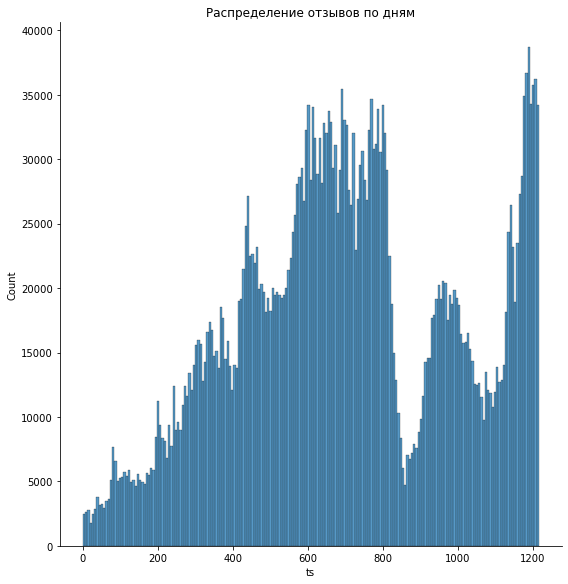

In [27]:
sns.displot(data=reviews, x='ts', height=8)
plt.title('Распределение отзывов по дням')
plt.show()

# Train-test split

In [28]:
from func import clear_df, extract_unique, count_unique, filter_reviews, train_test_split, process_reviews

In [29]:
print('Дней', reviews['ts'].max())

Дней 1216


**Всего в выборку попали отызывы за 1216 дней.**  Отложим в тестовую выборку отзывы за последние **100** дней.

In [30]:
train_reviews, test_reviews = train_test_split(reviews, 1116)
X_test, y_test = process_reviews(test_reviews)

Посмотрим, сколько всего уникальных пользователей попало в эту тестовую выборку:

In [31]:
len(X_test)

12044

# Метрика

Метрика принимает на вход два DataFrame, имеющих такую же структуру, как и **y_test**. `print_score` домножает реальное значение метрики на `100` так же, как и в контесте. Подобная имплементация используется для оценки **submission**.

In [32]:
from func import MNAP, print_score

In [33]:
N = 20
MNAP_N = MNAP(N)

# Подходы без машинного обучения

## Случайные N мест

Попробуем предлагать пользователям случайные места из другого города. 

In [34]:
# spb_orgs = orgs[orgs['city'] == 'spb']['org_id']
# msk_orgs = orgs[orgs['city'] == 'msk']['org_id']

test_users_with_locations = X_test.merge(users, on='user_id')

## N самых популярных мест

Предыдущий подход, очевидно, не очень удачно предсказывает, какие места посетит пользователей. 

Попробуем улучшить стратегию: будем предлагать пользователям самые популярные места, то есть те, на которые оставлено больше всего отзывов. 

In [35]:
msk_orgs = train_reviews[(train_reviews['rating'] >= 4) & (train_reviews['org_city'] == 'msk')]['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = train_reviews[(train_reviews['rating'] >= 4) & (train_reviews['org_city'] == 'spb')]['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()

In [36]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 4.24


Отлично, метрика немного улучшилась. Но стоит попробовать доработать эту тактику. 

## N самых популярных мест среди туристов

In [37]:
tourist_reviews = train_reviews[train_reviews['rating'] >= 4.0]

# набор отзывов только от туристов
tourist_reviews = tourist_reviews[tourist_reviews['user_city'] != tourist_reviews['org_city']]

# выбираем самые популярные места среди туристов из Москвы и Питера
msk_orgs = tourist_reviews[tourist_reviews['org_city'] == 'msk']['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = tourist_reviews[tourist_reviews['org_city'] == 'spb']['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()

In [38]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 6.44


Метрика улучшилась ещё!

## N самых популярных мест среди туристов с учетом оценки заведения

In [39]:
tourist_reviews = train_reviews[(train_reviews['rating'] >= 4.0) & (train_reviews['org_rating'] >=  4.0)]

# набор отзывов только от туристов
tourist_reviews = tourist_reviews[tourist_reviews['user_city'] != tourist_reviews['org_city']]

# выбираем самые популярные места среди туристов из Москвы и Питера
msk_orgs = tourist_reviews[tourist_reviews['org_city'] == 'msk']['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = tourist_reviews[tourist_reviews['org_city'] == 'spb']['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()

In [40]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 6.50


Метрика улучшилась ещё немного.

## N / rubrics_count самых популярных мест из каждой рубрики

In [41]:
from func import extract_top_by_rubrics

In [42]:
orgs.head(2)

,org_id,city,average_bill,org_rating,rubrics_id,features_id,feature_count
0,16848414477362211020,spb,1000.0,4.479702,"[30776, 31375]","[1018, 1509, 11177, 11617, 11629, 11704, 11867...",11
1,1430604733320164116,spb,1000.0,4.514509,"[30776, 30770]","[246, 1018, 11617, 11629, 11704, 11867, 20422,...",10


In [43]:
msk_orgs = extract_top_by_rubrics(orgs, tourist_reviews[tourist_reviews['org_city'] == 'msk'], N)
spb_orgs = extract_top_by_rubrics(orgs, tourist_reviews[tourist_reviews['org_city'] == 'spb'], N)

In [44]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 5.73


# Время ML! Коллаборативная фильтрация

## Memory-based

Для этой группы методов требуется явное построение матрицы __пользователь-организация__ (__interaction matrix__), где на пересечении `i`-ой строки и `j`-ого столбца будет рейтинг, который `i`-ый пользователь выставил `j`-ой организации или же пропуск, если рейтинг не был установлен. 

In [45]:
from func import reduce_reviews, create_mappings, map_ids, interaction_matrix

## ALS

In [46]:
import implicit  # !pip install implicit

In [47]:
def make_predictions(interactions, X_test, N, mod='ALS'):
    '''
    make_predictions(interactions, X_test, N)
        Делает рекомендации для пользователей из <X_test> на основе матрицы взаимодействий. 
        
        Parameters
        ----------
        interactions : scipy.sparse.csr_matrix
            Разреженная матрица взаимодействий.
            
        X_test : pd.DataFrame
            Набор тестовых пользователей, для которых нужно сделать рекомендации. 
        
        N : int
            Число рекомендаций для каждого пользователя. 
        
        Returns
        -------
        predictions : pd.DataFrame
            DataFrame с колонками <user_id> и <target>. 
            В <target> содержится список рекомендованных для пользователя org_id.
        
    '''
    
    
    predictions = X_test[['user_id']].copy()
    predictions['target'] = pd.Series(dtype=object)
    predictions = predictions.set_index('user_id')
    
    
    interactions, (train_users_len, inner_orgs_len), mappings = interactions
    (index_to_uid, uid_to_index), (index_to_oid, oid_to_index) = mappings

    base_model = implicit.als.AlternatingLeastSquares(
        factors=100,  iterations=150, 
        regularization=0.05,  random_state=42,
        #num_threads = 4,
        #calculate_training_loss=True
    )
    base_model.fit(interactions.T)

    
    orgs_to_filter = list(np.arange(inner_orgs_len))

    recommendations = base_model.recommend_all(
        interactions,
        N=N,
        filter_already_liked_items=True,
        filter_items=orgs_to_filter,
        show_progress=True
    )
    
    for user_id in tqdm(X_test['user_id'].values, leave=False):
        predictions.loc[user_id, 'target'] = list(
            map(
                lambda org_index: index_to_oid[org_index], 
                recommendations[uid_to_index[user_id]]
            )
        )
        
    return predictions.reset_index()

In [48]:
#mean_rating = train_reviews['rating'].mean()
train_reviews['rating'].fillna(0, inplace=True)


train_reviews = train_reviews[train_reviews['rating'] >= 3]
 
# train_reviews.dropna(inplace=True)
train_reviews.rating.isnull().sum()

2021-10-03 20:25:22,107 [3668] WARNING  py.warnings:109: [JupyterRequire] C:\Users\sasha\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(



0

In [49]:
msk_interactions = interaction_matrix(train_reviews,
                                      test_users_with_locations[test_users_with_locations['city'] == 'msk'],
                                      city = 'msk')

spb_interactions = interaction_matrix(train_reviews,
                                      test_users_with_locations[test_users_with_locations['city'] == 'spb'],
                                      city = 'spb')       
        
test_msk_users = test_users_with_locations[test_users_with_locations['city'] == 'msk']
test_spb_users = test_users_with_locations[test_users_with_locations['city'] == 'spb']

# Делаем предсказания
msk_predictions = make_predictions(msk_interactions, test_msk_users, N)
spb_predictions = make_predictions(spb_interactions, test_spb_users, N)

predictions = pd.concat([msk_predictions, spb_predictions])

print_score(MNAP_N(y_test, predictions))

Собираем матрицу взаимодействий: all_users: 29832 all_orgs: 15092
Собираем матрицу взаимодействий: all_users: 23327 all_orgs: 15092


# Submission

Выберем лучший метод на валидации, переобучим его на всей выборке и сделаем предсказание на тестовой выборке. 

**Формат вывода:**
Для каждого пользователя из файла `test_users.csv` необходимо приложить список из не более чем 20 организаций, относящихся к городу, отличному от города проживания пользователя.

## Without ML

In [54]:
# набор отзывов только от туристов


tourist_reviews = reviews[(reviews['rating'] >= 4.0) & (reviews['org_rating'] >= 4.0)]
tourist_reviews = tourist_reviews[tourist_reviews['user_city'] != tourist_reviews['org_city']]

# выбираем самые популярные места среди туристов из Москвы и Питера
msk_orgs = tourist_reviews[tourist_reviews['org_city'] == 'msk']['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = tourist_reviews[tourist_reviews['org_city'] == 'spb']['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()


msk_orgs = str(' '.join(map(str, msk_orgs)))
spb_orgs = str(' '.join(map(str, spb_orgs)))

In [55]:
test_users = pd.read_csv('data/test_users.csv')
test_users['city'] = test_users.merge(users, on='user_id')['city']
test_users.head(3)

,user_id,city
0,3545210947248911048,msk
1,15271987121288045390,msk
2,15016858616184265932,msk
3,12457244142928722989,msk
4,13339684649926251468,spb


In [56]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users.apply(choose, axis=1)
 
predictions = test_users[['user_id']]
predictions['target'] = target

predictions.head()

,user_id,target
0,3545210947248911048,12046097390037935713 5002407858008059043 14814...
1,15271987121288045390,12046097390037935713 5002407858008059043 14814...
2,15016858616184265932,12046097390037935713 5002407858008059043 14814...
3,12457244142928722989,12046097390037935713 5002407858008059043 14814...
4,13339684649926251468,15250345250621165867 9104453017196776235 16259...


In [57]:
predictions.to_csv('answers.csv', index=None)

## With ML

In [58]:
# mean_rating = reviews['rating'].mean()
# reviews['rating'].fillna(mean_rating, inplace=True)
# reviews = reviews[reviews['rating'] > 3]
# reviews

In [59]:
test_users = pd.read_csv('data/test_users.csv')
test_users = test_users.merge(users, on='user_id')

msk_interactions = interaction_matrix(
    reviews,                                  
    test_users[test_users['city'] == 'msk'][['user_id', 'city']],
    city = 'msk'
)

spb_interactions = interaction_matrix(
    reviews,
    test_users[test_users['city'] == 'spb'][['user_id', 'city']],
    city = 'spb'
)

msk_predictions = make_predictions(msk_interactions, test_msk_users, N)
spb_predictions = make_predictions(spb_interactions, test_spb_users, N)

predictions = pd.concat([msk_predictions, spb_predictions])

Собираем матрицу взаимодействий: all_users: 40014 all_orgs: 18321
Собираем матрицу взаимодействий: all_users: 29303 all_orgs: 18321


ModelFitError: NaN encountered in factors

In [ ]:
predictions['target'] = predictions['target'].apply(lambda orgs: ' '.join(map(str, orgs)))
predictions.head(2)

In [ ]:
predictions.to_csv('answers_ml.csv', index=None)

In [ ]:
print(len(reviews))
surprise_reviews = reviews[(reviews.rating > 4) & (reviews.org_rating > 4.5)]
print(len(surprise_reviews))

# Surprise - SVD/KNN и другие (Андрей/Саша)

In [63]:
from surprise import Reader, Dataset

from surprise import SVD,SVDpp
from surprise import NMF,BaselineOnly, NormalPredictor, KNNWithZScore, SlopeOne, CoClustering
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

In [64]:
ratings_dict = {'itemID': list(surprise_reviews.org_id),
                'userID': list(surprise_reviews.user_id),
                'rating': list(surprise_reviews.rating)}

surprise_reviews = pd.DataFrame(ratings_dict)
print('Filtered reviews', len(surprise_reviews))

# A reader is still needed but only the rating_scale param is required.
# The Reader class is used to parse a file containing ratings.
reader = Reader(rating_scale=(4.0, 5.0))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(surprise_reviews[['userID', 'itemID', 'rating']], reader)

Filtered reviews 417302


In [ ]:
surprise_reviews.head()

In [ ]:
# svd
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3, verbose=True, n_jobs=3)
#evaluate(algo, data, measures=['RMSE'])


# Использование NLP данных (Андрей)

# LightFM (Саша)

In [ ]:
def make_predictions_LightFM(interactions, X_test, N, mod='ALS'):
    '''
    make_predictions(interactions, X_test, N)
        Делает рекомендации для пользователей из <X_test> на основе матрицы взаимодействий. 
        
        Parameters
        ----------
        interactions : scipy.sparse.csr_matrix
            Разреженная матрица взаимодействий.
            
        X_test : pd.DataFrame
            Набор тестовых пользователей, для которых нужно сделать рекомендации. 
        
        N : int
            Число рекомендаций для каждого пользователя. 
        
        Returns
        -------
        predictions : pd.DataFrame
            DataFrame с колонками <user_id> и <target>. 
            В <target> содержится список рекомендованных для пользователя org_id.
        
    '''
    
    
    predictions = X_test[['user_id']].copy()
    predictions['target'] = pd.Series(dtype=object)
    predictions = predictions.set_index('user_id')
    
    
    interactions, (train_users_len, inner_orgs_len), mappings = interactions
    
  
    
    (index_to_uid, uid_to_index), (index_to_oid, oid_to_index) = mappings

    
    base_model = LightFM(loss='warp')
    base_model.fit(train,
              user_features=user_features,
              item_features=item_features,
              epochs=20)
    predictions = base_model.predict(test_user_ids,
                                test_item_ids,
                                # user_features=user_features,
                                item_features=item_features)


    
#     base_model = implicit.als.AlternatingLeastSquares(
#         factors=100,  iterations=150, 
#         regularization=0.05,  random_state=42,
#         #num_threads = 4,
#         #calculate_training_loss=True
#     )
#     base_model.fit(interactions.T)

    
    
    
    
    orgs_to_filter = list(np.arange(inner_orgs_len))

    recommendations = base_model.recommend_all(
        interactions,
        N=N,
        filter_already_liked_items=True,
        filter_items=orgs_to_filter,
        show_progress=True
    )
    
    for user_id in tqdm(X_test['user_id'].values, leave=False):
        predictions.loc[user_id, 'target'] = list(
            map(
                lambda org_index: index_to_oid[org_index], 
                recommendations[uid_to_index[user_id]]
            )
        )
        
    return predictions.reset_index()

In [63]:
msk_interactions = interaction_matrix(train_reviews,
                                      test_users_with_locations[test_users_with_locations['city'] == 'msk'],
                                      city = 'msk')
 
    
# Делаем предсказания
msk_predictions = make_predictions(msk_interactions, 
                                   test_users_with_locations[test_users_with_locations['city'] == 'msk'], N)
 

predictions = pd.concat([msk_predictions, spb_predictions])

print_score(MNAP_N(y_test, predictions))

Собираем матрицу взаимодействий: all_users: 29832 all_orgs: 15092
Собираем матрицу взаимодействий: all_users: 23327 all_orgs: 15092


Score: 0.56


In [ ]:
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k

# Instantiate and train the model


predictions = X_test[['user_id']].copy()
predictions['target'] = pd.Series(dtype=object)
predictions = predictions.set_index('user_id')


msk_interactions = interaction_matrix(train_reviews,
                                      test_users_with_locations[test_users_with_locations['city'] == 'msk'],
                                      city = 'msk')

interactions, (train_users_len, inner_orgs_len), mappings = msk_interactions
(index_to_uid, uid_to_index), (index_to_oid, oid_to_index) = mappings

In [68]:
model = LightFM(loss='warp')

model.fit(interactions,
#           user_features=user_features,
#           item_features=item_features,
          epochs=20)
print('Обучился')
test_item_ids = np.arange(inner_orgs_len)
test_user_ids = np.arange(train_users_len)

predictions = model.predict(test_user_ids,
                            test_item_ids,
#                             user_features=user_features,
#                             item_features=item_features
                           )


# # Evaluate the trained model
# test_precision = precision_at_k(model, data['test'], k=5).mean()
# test_precision

Обучился


AssertionError: 